# Text Summarization: 02. Preprocessing

## Import libraries

In [1]:
import os
from datasets import DatasetDict, load_from_disk
from matplotlib import pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [2]:
# set variables
SEED = 1234
curr_path = os.getcwd()
path_raw = os.path.join(curr_path, '../data/raw', 'bill_summary_us')
# dataset_name = 'vgoldberg/longform_article_summarization'
dataset_name = 'dreamproit/bill_summary_us'
path_preprocessed = os.path.join(curr_path, '../data/preprocessed', 'bill_summary_us_single_section')

## Helper functions

In [3]:
def print_example(example: dict) -> None:
    """Print example.
    :param example: dict, example.
    """
    print(' '.join(['=' * 10, 'text', '=' * 10]))
    print(example['text'])
    print(' '.join(['=' * 10, 'summary', '=' * 10]))
    print(example['summary'])    


def remove_missing_data(example: dict, col_list: list[str]) -> bool:
    """Remove missing data.
    :param example: dict, example.
    :param col_list, list[str], list of columns.
    :return: bool, whether valid (True) or missing data (False). 
    """
    flag_value = True
    for col in col_list:
        flag_value = flag_value and example[col] is not None
    return flag_value


def count_words(example: dict, col_list: list[str]) -> dict:    
    """Count words.
    :param example: dict, example.
    :param col_list, list[str], list of columns.
    :return: dict, count dictionary with prefix `count_`.
    """
    count_dict = {}
    for col_name in col_list:
        col_count = '_'.join(['count', col_name])
        word_count = len(example[col_name].split())
        count_dict[col_count] = word_count
    return count_dict


def process_tab(example: dict, col: str) -> dict:    
    """Process tab. Remove triple tabs then replace a tab with space.
    :param example: dict, example.
    :param col: str, column name to process.
    :return, dict, processed example.
    """
    example[col] = example[col].replace('\t\t\t', '').replace('\t', ' ')
    return example


def plot_text_length(df: pd.DataFrame, col_list: list[str]) -> tuple:
    """Plot historgram of text length.
    :param df, pd.DataFrame, input dataframe.
    :param col_list: list[str], a list of column names.
    :return: tuple, (fig, axis_tuple).
        - fig: matplotlib.figure, figure handle.
        - axis_tuple: tuple[matplotlib.axes.Axes], a tuple of axes.
    """
    num_col = len(col_list)
    fig, axis_tuple = plt.subplots(nrows=1, ncols=num_col, figsize=[6.4 * num_col, 4.8])
    for idx, col in enumerate(col_list):
        ax = axis_tuple[idx]
        _ = df.plot(y=col, kind='hist', bins=100, ax=ax)  

    return fig, axis_tuple


def find_outliers_cutoff(df: pd.DataFrame, scale: float = 1.5) -> dict[tuple]:
    """Find outliers cutoff.
    :param df, pd.DataFrame, input dataframe.
    :param scale: float, scale factor for IQR to define whiskter. Default: 1.5.
    :return: dict[tuple], a dictionary of lower and upper cutoff for each column.
    """
    # upper, lower whisker: pd.Series
    q3 = df.quantile(q=0.75)
    q1 = df.quantile(q=0.25)
    iqr = q3 - q1
    upper = q3 + scale * iqr
    lower = q1 - scale * iqr
    
    upper_dict = upper.to_dict()
    lower_dict = lower.to_dict()
    cutoff_dict = {}
    for key in upper_dict:
        cutoff_dict[key] = (lower_dict[key], upper_dict[key])
    return cutoff_dict    


def remove_outliers(example: dict, col_list: list, cutoff_dict: dict[tuple]) -> bool:
    """Remove outliers.
    :param example: dict, example.
    :param col_list, list[str], list of columns.
    :param cutoff_dict: dict[tuple], a dictionary of lower and upper cutoff for each column.
    :return: bool, whether valid (True) or outliers (False).
    """
    flag_val = True
    for col in col_list:
        cutoff_low, cutoff_high = cutoff_dict[col]
        flag_val = flag_val and cutoff_low <= example[col] <= cutoff_high
    return flag_val


def create_prompt(example: dict, col_text: str, prompt_prefix: str) -> dict:
    """Creat prompt with prompt prefix.
    :param example: dict, example.
    :param col_text: str, column for text.
    :param prompt_prefix: str, prompt prefix for instruction.
    :return: dict, example with prompt column.
    """
    example['prompt'] = f'{prompt_prefix}: {example[col_text]}'
    return example


#  build system to tokenize
def tokenize_example(
    example: dict, tokenizer: AutoTokenizer, col_prompt: str, col_summary: str, 
    max_input_length: int, max_target_length: int
) -> dict: 
    """Tokenize example.
    :param example: dict, example.
    :param tokenizer: transformers.AutoTokenizer, tokenizer.
    :param col_prompt: str, column name for prompt.
    :param col_summary: str, column name for summary (target)
    :param max_input_length: int, maximum input token length. 
    :param max_target_length: int, maximum target token length. 
    :return: dict, tokens for input ('input_ids') and target ('label').
    """
    model_input = tokenizer(
        example[col_prompt], 
        max_length=max_input_length, 
        truncation=True,
        # return_tensors='pt',
    )
    label = tokenizer(
        # example[col_summary], 
        text_target=example[col_summary], 
        max_length=max_target_length, 
        truncation=True,
        # return_tensors='pt',
    )
    model_input['label'] = label['input_ids']
    return model_input


def count_tokens(example: dict, col_list: list[str]) -> dict:    
    """Count tokens.
    :param example: dict, example.
    :param col_list: list[str], a list of column names.
    :return: dict, token counts with prefix 'count_tokens_'
    """
    count_dict = {}
    for col_name in col_list:
        col_count = '_'.join(['count_tokens', col_name])
        word_count = len(example[col_name])
        count_dict[col_count] = word_count
    return count_dict


def preprocessing(ds, col_names, cutoff_dict, col_for_count, tokenizer, max_input_length, max_target_length):   
    ds_preprocessed = ( 
        # 1. remove missing
        ds.filter(remove_missing_data, fn_kwargs={'col_list': col_names})
        
        # 2. filtering
        # select only 1 section
        .filter(lambda example: example['sections_length'] == 1, num_proc=12)
        # remove any zero text length, summary_length
        .filter(lambda example: example['text_length'] > 0, num_proc=12)
        .filter(lambda example: example['summary_length'] > 0, num_proc=12)
        # text_length_outliers, summary_length_outliers
        .filter(remove_outliers, fn_kwargs={'col_list': list(cutoff_dict.keys()), 'cutoff_dict': cutoff_dict}, num_proc=12)

        # count words
        .map(count_words, fn_kwargs={'col_list': col_for_count}, num_proc=12)
        
        # remove \t\t\t, and replace \t with ' '
        .map(process_tab, fn_kwargs={'col': 'text'}, num_proc=12)
        
        # create prompt
        .map(create_prompt, fn_kwargs={'col_text': 'text', 'prompt_prefix': 'summarize'}, num_proc=12)
        
        # tokenize: need to specify max_input_length, when number of tokens is greater than default limit (512)
        .map(
            tokenize_example, 
            fn_kwargs={
                'tokenizer': tokenizer, 'col_prompt': 'prompt', 'col_summary': 'summary', 
                'max_input_length': max_input_length, 'max_target_length': max_target_length, 
            },
            batched=True, 
            batch_size=500,
            num_proc=12,
        )

        # count tokens
        .map(count_tokens, fn_kwargs={'col_list': ['input_ids', 'label']}, num_proc=12)
    )
    return ds_preprocessed

## Load dataset

In [4]:
# load dataset
ds_temp = load_from_disk(dataset_path=path_raw)
print(ds_temp)
# clean up cache
ds_temp.cleanup_cache_files()

DatasetDict({
    train: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title'],
        num_rows: 100196
    })
    dev: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title'],
        num_rows: 12525
    })
    test: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title'],
        num_rows: 12525
    })
})


{'train': 110, 'dev': 109, 'test': 109}

In [5]:
# access record
print(ds_temp['train'][0])
print_example(example=ds_temp['train'][0])
# there are multiple sections: 'text' combines all sections. {text, id header}

{'id': '111hr5783ih', 'congress': 111, 'bill_type': 'hr', 'bill_number': 5783, 'bill_version': 'ih', 'sections': [{'text': '1. Short title;\t\t\t findings \n(a) Short\t\t\t title \nThis Act may be cited\t\t\t as the Investing in Our Future Act of\t\t\t 2010. (b) Findings \nCongress\t\t\t finds the following: (1) While Wall Street continues to reap massive\t\t\t profits, the 2008 global economic crisis they helped cause has destabilized\t\t\t economies and impacted the budgets of the United States and impoverished\t\t\t nations, compromising the ability of governments to address pressing\t\t\t needs. (2) Currency\t\t\t speculation has destabilizing impacts on the real economy and can contribute to\t\t\t financial crises. (3) Millions of people\t\t\t around the world have been pushed into poverty because of the global financial\t\t\t crisis, through no fault of their own. (4) The impacts of\t\t\t climate change, disease, and ill health undermine the economies of developing\t\t\t nations 

In [6]:
print(ds_temp['train'].features)
print(type(ds_temp['train']))

{'id': Value(dtype='string', id=None), 'congress': Value(dtype='int64', id=None), 'bill_type': Value(dtype='string', id=None), 'bill_number': Value(dtype='int64', id=None), 'bill_version': Value(dtype='string', id=None), 'sections': [{'text': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'header': Value(dtype='string', id=None)}], 'sections_length': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), 'text_length': Value(dtype='int64', id=None), 'summary': Value(dtype='string', id=None), 'summary_length': Value(dtype='int64', id=None), 'title': Value(dtype='string', id=None)}
<class 'datasets.arrow_dataset.Dataset'>


## EDA
*  the number of words of text, summary

In [7]:
# remove missing data
col_names = ds_temp['train'].column_names

# ds_temp.filter(lambda example: (example['text'] is not None) and (example['text'] is not None), num_proc=12)
train = ds_temp['train'].filter(remove_missing_data, fn_kwargs={'col_list': col_names}, num_proc=12)
print(train)

Filter (num_proc=12):   0%|          | 0/100196 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title'],
    num_rows: 100196
})


In [8]:
# extract: bill_type, sections_length, text_length, summary_length
col_for_df = ['bill_type', 'sections_length', 'text_length', 'summary_length']
meta_train_df = ( 
    train.select_columns(col_for_df)
    .to_pandas()
)
meta_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100196 entries, 0 to 100195
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   bill_type        100196 non-null  object
 1   sections_length  100196 non-null  int64 
 2   text_length      100196 non-null  int64 
 3   summary_length   100196 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.1+ MB


In [9]:
# value counts
print(meta_train_df['bill_type'].value_counts())
print(meta_train_df['sections_length'].value_counts()[:10])
print(meta_train_df['sections_length'].value_counts()[:10])
# what is sections_length = 0?
# for now, 1 section 

bill_type
hr         53814
s          28420
hres        9185
sres        5201
hconres     1809
hjres        863
sconres      501
sjres        403
Name: count, dtype: int64
sections_length
1     28890
2     24713
3     13805
4      7754
5      5094
6      3480
7      2871
8      2178
9      1740
10     1299
Name: count, dtype: int64
sections_length
1     28890
2     24713
3     13805
4      7754
5      5094
6      3480
7      2871
8      2178
9      1740
10     1299
Name: count, dtype: int64


In [10]:
# sections_length = 0
print(train.filter(lambda example: example['sections_length'] == 0, num_proc=12)[0])
display(meta_train_df.loc[meta_train_df['sections_length'] == 0])
# verify other text_length == 0, summary_length == 0
display(meta_train_df.loc[meta_train_df['text_length'] == 0])
display(meta_train_df.loc[meta_train_df['summary_length'] == 0])

Filter (num_proc=12):   0%|          | 0/100196 [00:00<?, ? examples/s]

{'id': '117hr3239ih', 'congress': 117, 'bill_type': 'hr', 'bill_number': 3239, 'bill_version': 'ih', 'sections': [], 'sections_length': 0, 'text': '', 'text_length': 0, 'summary': 'This bill makes technical and conforming changes to the U.S. Code that are related to the enactment of title 41 (Public Contracts) into positive law.', 'summary_length': 149, 'title': 'To make improvements in the enactment of title 41, United States Code, into a positive law title and to improve the Code.'}


,bill_type,sections_length,text_length,summary_length
100133,hr,0,0,149


,bill_type,sections_length,text_length,summary_length
100133,hr,0,0,149


,bill_type,sections_length,text_length,summary_length


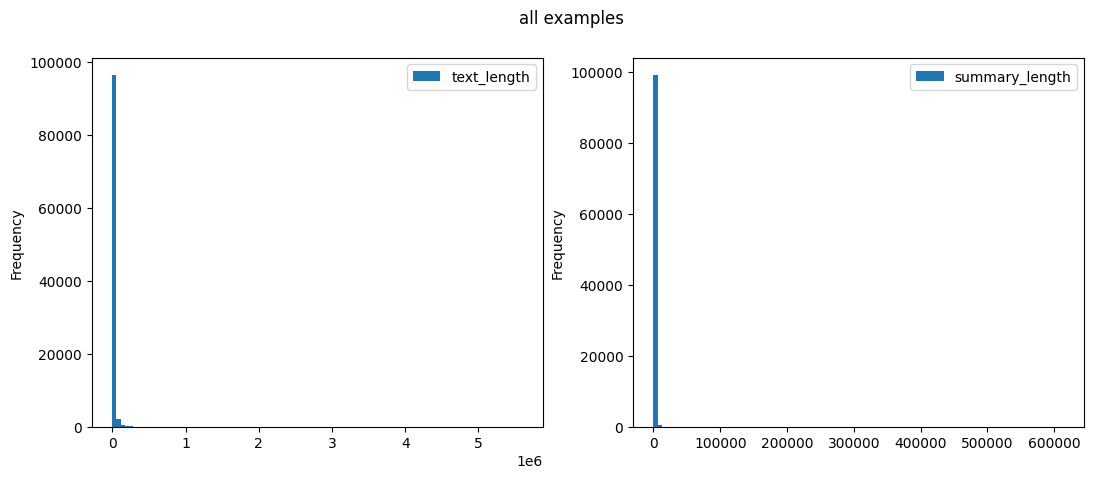

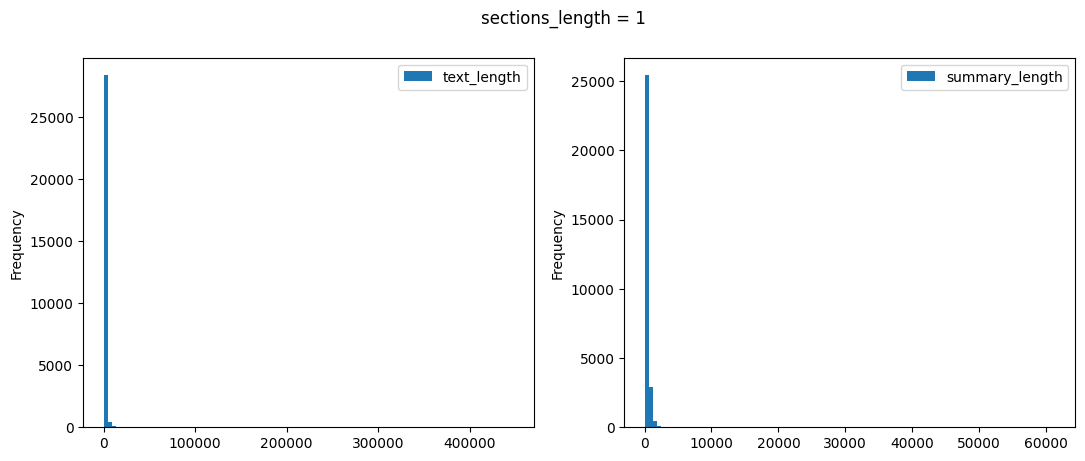

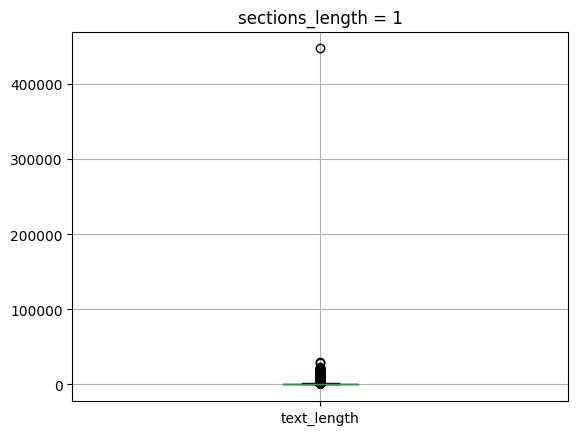

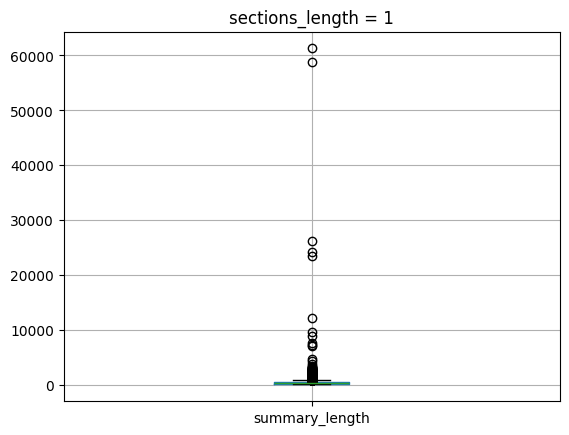

In [11]:
plot_text_length(meta_train_df, ['text_length', 'summary_length'])
_ = plt.suptitle('all examples')
plot_text_length(meta_train_df.loc[meta_train_df['sections_length'] == 1], ['text_length', 'summary_length'])
_ = plt.suptitle('sections_length = 1')

_ = plt.figure()
_ = meta_train_df.loc[meta_train_df['sections_length'] == 1, ['text_length']].boxplot()
_ = plt.title('sections_length = 1')

_ = plt.figure()
_ = meta_train_df.loc[meta_train_df['sections_length'] == 1, ['summary_length']].boxplot()
_ = plt.title('sections_length = 1')

In [12]:
cutoff_dict = find_outliers_cutoff(meta_train_df.loc[meta_train_df['sections_length'] == 1, ['text_length', 'summary_length']])
print(cutoff_dict)

{'text_length': (-566.0, 2018.0), 'summary_length': (-253.5, 846.5)}


In [13]:
train_filtered = ( 
    # select only 1 section
    train.filter(lambda example: example['sections_length'] == 1, num_proc=12)
    # remove any zero text length, summary_length
    .filter(lambda example: example['text_length'] > 0)
    .filter(lambda example: example['summary_length'] > 0)
    # text_length_outliers, summary_length_outliers
    .filter(remove_outliers, fn_kwargs={'col_list': list(cutoff_dict.keys()), 'cutoff_dict': cutoff_dict}, num_proc=12)
)

print(train_filtered)

# see how many examples survived
data_ratio_in_perc = train_filtered.num_rows / train.num_rows * 100
print(f'remaining data ratio: {data_ratio_in_perc: .4f} %.')


Filter (num_proc=12):   0%|          | 0/100196 [00:00<?, ? examples/s]

Filter:   0%|          | 0/28890 [00:00<?, ? examples/s]

Filter:   0%|          | 0/28890 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/28890 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title'],
    num_rows: 24861
})
remaining data ratio:  24.8124 %.


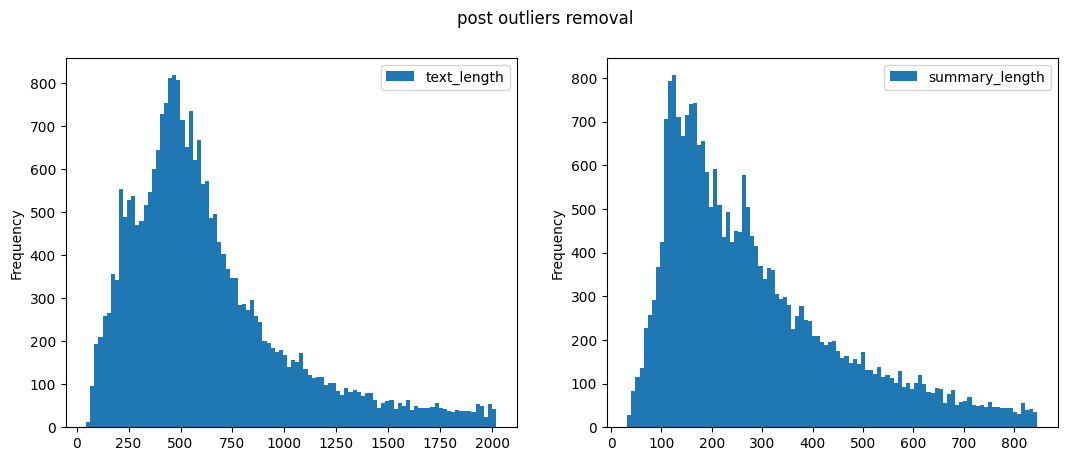

In [14]:
fig2, (ax1, ax2) = plot_text_length(train_filtered.select_columns(['text_length', 'summary_length']).to_pandas(), col_list=['text_length', 'summary_length'])
_ = fig2.suptitle('post outliers removal')

In [15]:
# count words
col_for_count = ['text', 'summary']
train_filtered = train_filtered.map(count_words, fn_kwargs={'col_list': col_for_count}, num_proc=12)

# count_train.set_format('pandas')
# return whole dataset
count_train_df = train_filtered.select_columns(['count_text', 'count_summary']).to_pandas()

Map (num_proc=12):   0%|          | 0/24861 [00:00<?, ? examples/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24861 entries, 0 to 24860
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   count_text     24861 non-null  int64
 1   count_summary  24861 non-null  int64
dtypes: int64(2)
memory usage: 388.6 KB
None
         count_text  count_summary
count  24861.000000   24861.000000
mean      97.658461      43.496561
std       60.577673      26.741416
min        8.000000       4.000000
25%       58.000000      23.000000
50%       83.000000      36.000000
75%      120.000000      57.000000
max      390.000000     146.000000
count_text       390
count_summary    146
dtype: int64


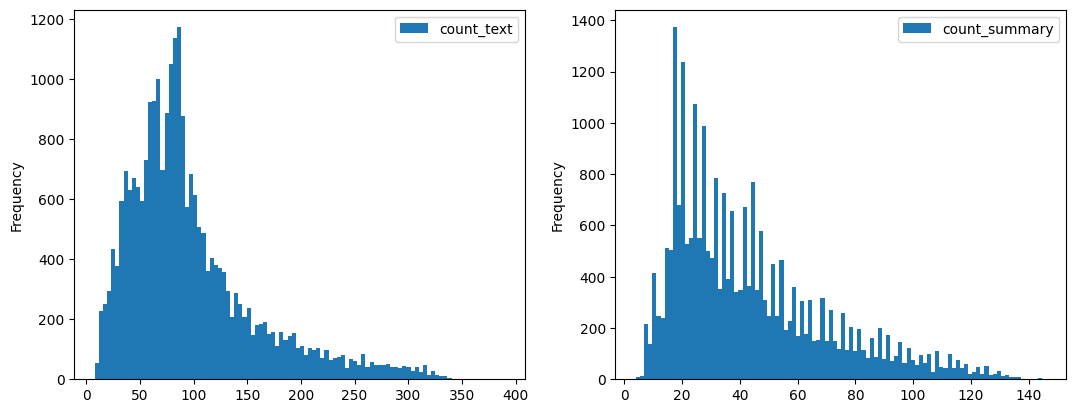

In [16]:
print(count_train_df.info())
print(count_train_df.describe())
_ = plot_text_length(count_train_df, col_list=['count_text', 'count_summary'])
print(count_train_df.max())

In [17]:
# model_checkpoint = 'google/flan-t5-small'
model_checkpoint = 'google/flan-t5-base'
# model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [18]:
# should creat prompt and tokenize
# think about \t\t\t
train_preprocessed = train_filtered.map(process_tab, fn_kwargs={'col': 'text'}, num_proc=12)
# create prompt
train_preprocessed = train_preprocessed.map(create_prompt, fn_kwargs={'col_text': 'text', 'prompt_prefix': 'summarize'}, num_proc=12)
# tokenize: need to specify max_input_length, when number of tokens is greater than default limit (512)
max_input_length = 1024
max_target_length = 512
tokenized_train = train_preprocessed.map(
    tokenize_example, 
    fn_kwargs={
        'tokenizer': tokenizer, 'col_prompt': 'prompt', 'col_summary': 'summary', 
        'max_input_length': max_input_length, 'max_target_length': max_target_length, 
    },
    batched=True, 
    batch_size=500,
    num_proc=12,
)

# tokenize


Map (num_proc=12):   0%|          | 0/24861 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/24861 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/24861 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/24861 [00:00<?, ? examples/s]

count_tokens_input_ids    12
count_tokens_label         9
dtype: int64
count_tokens_input_ids    796
count_tokens_label        334
dtype: int64
Dataset({
    features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title', 'count_text', 'count_summary', 'prompt', 'input_ids', 'attention_mask', 'label', 'count_tokens_input_ids', 'count_tokens_label'],
    num_rows: 24861
})


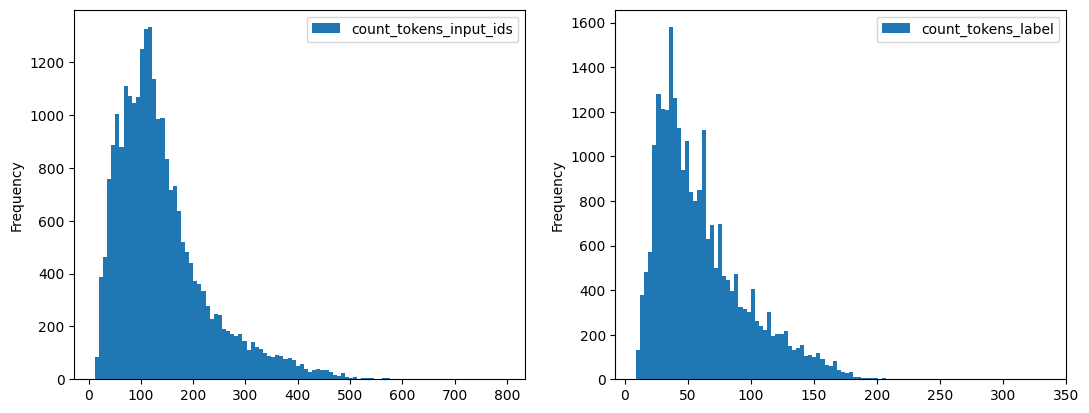

In [19]:
# count tokens
tokenized_train = tokenized_train.map(count_tokens, fn_kwargs={'col_list': ['input_ids', 'label']}, num_proc=12)

# token counts
count_tokens_df = tokenized_train.select_columns(['count_tokens_input_ids', 'count_tokens_label']).to_pandas()
print(count_tokens_df.min())
print(count_tokens_df.max())
_ = plot_text_length(count_tokens_df, col_list=['count_tokens_input_ids', 'count_tokens_label'])

print(tokenized_train)

In [20]:
# summary ratio
summary_ratio = count_tokens_df['count_tokens_label'] / count_tokens_df['count_tokens_input_ids']
# summary_ratio.plot(kind='hist')
print(len(summary_ratio[(summary_ratio > 1)].index))
print(summary_ratio[(summary_ratio > 1)].index)
print(summary_ratio.describe())
# tokenized_train.select_columns(['text', 'summary'])[(summary_ratio > 1)]

2228
Index([   19,    40,    64,    93,   102,   126,   152,   178,   191,   199,
       ...
       24712, 24713, 24749, 24770, 24778, 24779, 24782, 24797, 24819, 24849],
      dtype='int64', length=2228)
count    24861.000000
mean         0.552524
std          0.367244
min          0.023622
25%          0.276316
50%          0.467290
75%          0.774194
max          5.333333
dtype: float64


,count_tokens_input_ids,count_tokens_label
count,22484.000000,22484.000000
mean,148.961350,59.170121
std,87.667488,35.207066
min,15.000000,9.000000
25%,90.000000,33.000000
50%,127.000000,49.000000
75%,185.000000,76.000000
max,796.000000,334.000000


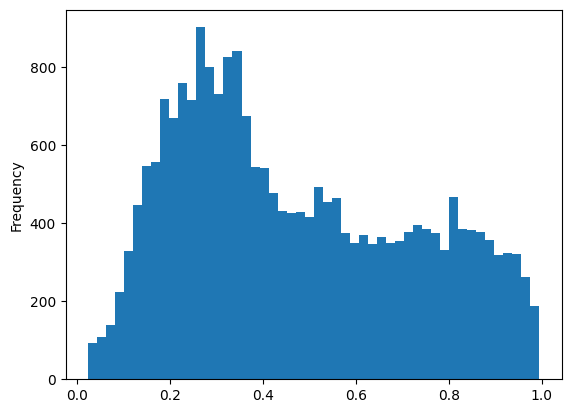

In [21]:
# 24861 remove 2228
summary_ratio[(summary_ratio < 1)].plot(kind='hist', bins=50)
count_tokens_df[(summary_ratio < 1)].describe()

## validation and test data

In [22]:
# validation
ds_preprocessed_dev = preprocessing(
    ds_temp['dev'], col_names, cutoff_dict, col_for_count, tokenizer, max_input_length, max_target_length
)
# test
ds_preprocessed_test = preprocessing(
    ds_temp['test'], col_names, cutoff_dict, col_for_count, tokenizer, max_input_length, max_target_length
)

# combined with tokenized_train

Filter:   0%|          | 0/12525 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/12525 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/3647 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/3647 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/3647 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3116 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3116 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3116 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3116 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3116 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12525 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/12525 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/3527 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/3527 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/3527 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3051 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3051 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3051 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3051 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3051 [00:00<?, ? examples/s]

In [23]:
# combined with tokenized_train
ds_preprocessed = DatasetDict(
    {
        'train': tokenized_train, 
        'dev': ds_preprocessed_dev, 
        'test': ds_preprocessed_test
    }
)
print(ds_preprocessed)

DatasetDict({
    train: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title', 'count_text', 'count_summary', 'prompt', 'input_ids', 'attention_mask', 'label', 'count_tokens_input_ids', 'count_tokens_label'],
        num_rows: 24861
    })
    dev: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title', 'count_text', 'count_summary', 'prompt', 'input_ids', 'attention_mask', 'label', 'count_tokens_input_ids', 'count_tokens_label'],
        num_rows: 3116
    })
    test: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title', 'count_text', 'count_summary', 'prompt', 'input_ids', 'attention_mask', 'label', 'coun

## Save preprocessed data

In [24]:
ds_preprocessed.save_to_disk(path_preprocessed)
!ls {path_preprocessed}

Saving the dataset (0/1 shards):   0%|          | 0/24861 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3116 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3051 [00:00<?, ? examples/s]

dataset_dict.json  dev	test  train


In [25]:
ds_preprocessed

DatasetDict({
    train: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title', 'count_text', 'count_summary', 'prompt', 'input_ids', 'attention_mask', 'label', 'count_tokens_input_ids', 'count_tokens_label'],
        num_rows: 24861
    })
    dev: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title', 'count_text', 'count_summary', 'prompt', 'input_ids', 'attention_mask', 'label', 'count_tokens_input_ids', 'count_tokens_label'],
        num_rows: 3116
    })
    test: Dataset({
        features: ['id', 'congress', 'bill_type', 'bill_number', 'bill_version', 'sections', 'sections_length', 'text', 'text_length', 'summary', 'summary_length', 'title', 'count_text', 'count_summary', 'prompt', 'input_ids', 'attention_mask', 'label', 'coun